# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Useful Functions

In [2]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Create Time Series

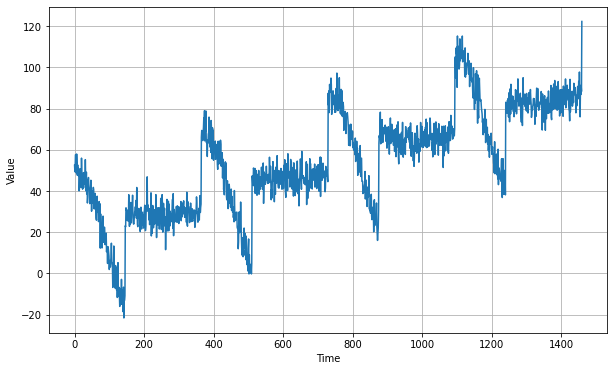

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
period = 365

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Splitting Time Series

In [4]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Creating windowed dataset

In [5]:
series.shape

(1461,)

In [7]:
series2 = tf.expand_dims(series, axis=-1)
print(series2.shape)
print(series.shape)

(1461, 1)
(1461,)


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
dataset = windowed_dataset(x_train, 
                           window_size, 
                           batch_size=128, 
                           shuffle_buffer=shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>


# **Conv1D + LSTM Model**

# Find Learning Rate & Create Model

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_conv1d = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,
                         kernel_size=3,
                         strides=1,
                         padding='causal',
                         activation='relu',
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model_conv1d.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
  metrics = ['mae']
)

model_conv1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_conv1d = model_conv1d.fit(dataset,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 45ms/step - loss: 55.5837 - mae: 56.0830
Epoch 2/100
8/8 [==============================] - 0s 44ms/step - loss: 55.3168 - mae: 55.8162
Epoch 3/100
8/8 [==============================] - 0s 44ms/step - loss: 54.8862 - mae: 55.3856
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 54.3560 - mae: 54.8553
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 53.7414 - mae: 54.2406
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 53.0449 - mae: 53.5441
Epoch 7/100
8/8 [==============================] - 0s 42ms/step - loss: 52.2755 - mae: 52.7746
Epoch 8/100
8/8 [==============================] - 0s 43ms/step - loss: 51.4124 - mae: 51.9115
Epoch 9/100
8/8 [==============================] - 0s 45ms/step - loss: 50.4569 - mae: 50.9560
Epoch 10/100
8/8 [==============================] - 1s 44ms/step - loss: 49.4022 - mae: 49.9013
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

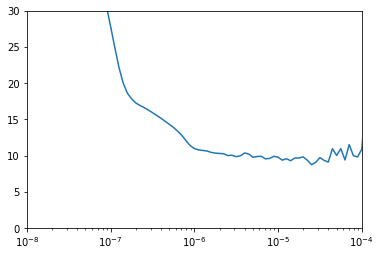

In [30]:
plt.semilogx(history_conv1d.history["lr"], 
             history_conv1d.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_conv1d = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,
                         kernel_size=3,
                         strides=1,
                         padding='causal',
                         activation='relu',
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])


model_conv1d.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
  metrics = ['mae']
)

model_conv1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_conv1d.layers[0].output_shape

(None, None, 32)

In [33]:
model_conv1d.layers[0].input_shape

(None, None, 1)

In [34]:
history_conv1d = model_conv1d.fit(dataset,
                                  epochs=500)

Epoch 1/500
8/8 [==============================] - 4s 44ms/step - loss: 33.8626 - mae: 34.3603
Epoch 2/500
8/8 [==============================] - 0s 43ms/step - loss: 20.0280 - mae: 20.5235
Epoch 3/500
8/8 [==============================] - 0s 43ms/step - loss: 16.0765 - mae: 16.5701
Epoch 4/500
8/8 [==============================] - 0s 42ms/step - loss: 12.7631 - mae: 13.2535
Epoch 5/500
8/8 [==============================] - 0s 43ms/step - loss: 11.1480 - mae: 11.6371
Epoch 6/500
8/8 [==============================] - 0s 42ms/step - loss: 9.9998 - mae: 10.4860
Epoch 7/500
8/8 [==============================] - 0s 42ms/step - loss: 9.7290 - mae: 10.2148
Epoch 8/500
8/8 [==============================] - 0s 45ms/step - loss: 9.7136 - mae: 10.2006
Epoch 9/500
8/8 [==============================] - 0s 42ms/step - loss: 9.5194 - mae: 10.0049
Epoch 10/500
8/8 [==============================] - 1s 44ms/step - loss: 9.2565 - mae: 9.7418
Epoch 11/500
8/8 [==============================] - 0s 

# Forecast

In [35]:
forecast_result = model_forecast(model_conv1d, 
                                 series[..., np.newaxis], 
                                 window_size)

forecast_result = forecast_result[split_time - window_size:-1, -1, 0]

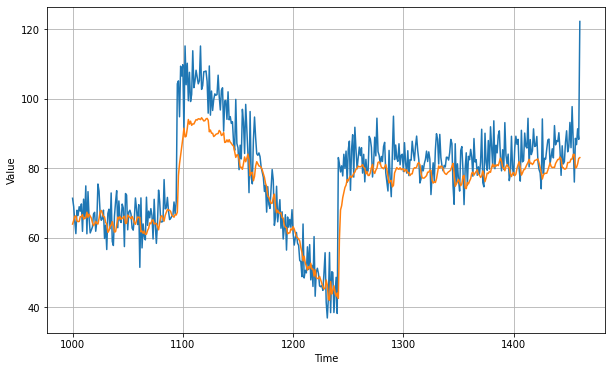

In [36]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, forecast_result)

# Loss

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast_result).numpy()

6.039238

# Plot Loss

<Figure size 432x288 with 0 Axes>

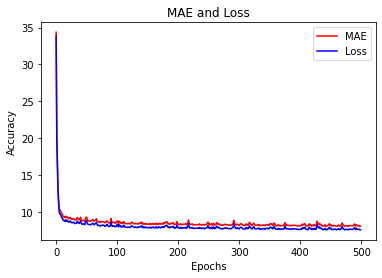

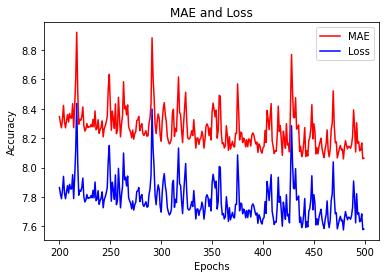

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_conv1d.history['mae']
loss=history_conv1d.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()